In [1]:
# !pip install scikit-image

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-13 10:10:04.302042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 10:10:06.270974: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-09-13 10:10:06.271271: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-09-13 10:10:06.277309: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-09-13 10:10:06.513125: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [3]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

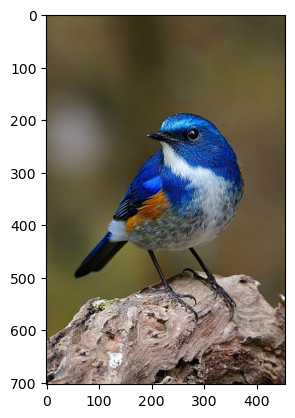

In [4]:
plt.imshow(image)
plt.show()

In [5]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [6]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [7]:
image_array.shape

(703, 454, 3)

In [8]:
image_array = image_array.reshape((1,) + image_array.shape)

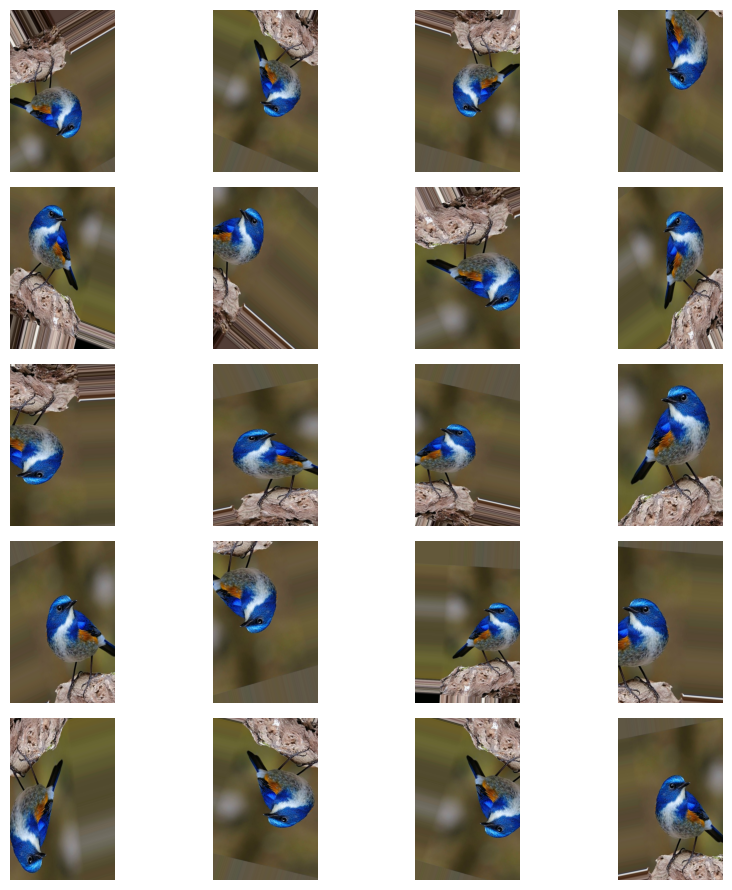

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [10]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2
import tensorflow as tf

# GPU 디바이스 설정
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [11]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

2024-09-13 10:03:44.877470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 10:03:44.881196: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) Graphics)
2024-09-13 10:03:45.072082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 10:03:45.072272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [13]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
# model.summary()

In [14]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [4]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [5]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [6]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [ ]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-13 09:27:35.176172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 09:27:35.586492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 09:27:35.586554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

2024-09-13 09:27:47.774756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 09:27:48.116334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 09:27:48.116397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - 24s 15s/step - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6929 - val_accuracy: 0.5273
Epoch 2/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 3/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6927 - val_accuracy: 0.5273
Epoch 4/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 5/2000
2/2 [==============================] - 19s 14s/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 6/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 7/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6925 - accuracy: 0.5273 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 8/2000
2/2 [========

Epoch 59/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 60/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 61/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 62/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 63/2000
2/2 [==============================] - 18s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 64/2000
2/2 [==============================] - 18s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 65/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 

# Resnet

In [ ]:
base_model2 = ResNet152V2(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

In [ ]:
base_model2.summary()

In [ ]:
base_model2.trainable = False
model2 = Sequential()
model2.add(base_model2)
model2.add(Dense(2, activation='sigmoid'))
# model.summary()

In [ ]:
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [ ]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [ ]:
history2=model2.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

======================================================================

In [7]:
from tensorflow.keras.models import load_model

In [11]:
res50_model = load_model("./catanddog/Resnet50_catndog.keras")

In [12]:
res50_pred =res50_model.predict(valid_gen)
res50_pred 

2024-09-13 10:14:27.814082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 7s 3s/step


2024-09-13 10:14:34.089945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 10:14:34.090042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-13 10:14:34.094618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 10:14:34.094704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: 

array([[0.48028535, 0.51814264],
       [0.4804718 , 0.5181479 ],
       [0.48015997, 0.5180849 ],
       [0.4806584 , 0.51817626],
       [0.48050818, 0.51818395],
       [0.48059785, 0.51822823],
       [0.4804975 , 0.5182421 ],
       [0.48051092, 0.5181635 ],
       [0.48042187, 0.51773685],
       [0.48066643, 0.5181108 ],
       [0.48075086, 0.51822144],
       [0.4805067 , 0.51822805],
       [0.48069635, 0.51816934],
       [0.48073554, 0.5181697 ],
       [0.4804292 , 0.51806986],
       [0.4803388 , 0.51830655],
       [0.48041472, 0.5181687 ],
       [0.4805339 , 0.5181247 ],
       [0.48059082, 0.5182475 ],
       [0.48076108, 0.5181798 ],
       [0.4804773 , 0.51811785],
       [0.48043355, 0.5182074 ],
       [0.48076892, 0.51817364],
       [0.48044032, 0.5182104 ],
       [0.4803991 , 0.518147  ],
       [0.48053956, 0.5181431 ],
       [0.4805873 , 0.51816607],
       [0.48058158, 0.51818645],
       [0.48031703, 0.5180095 ],
       [0.48074633, 0.5181092 ],
       [0.

In [13]:
class_names = ['cat','dog']
validation, label_batch =next(iter(valid_gen))
pred_values = np.argmax(res50_pred, axis=1)



In [14]:
pred_values


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
#고양이는 예측을 하나도 못함

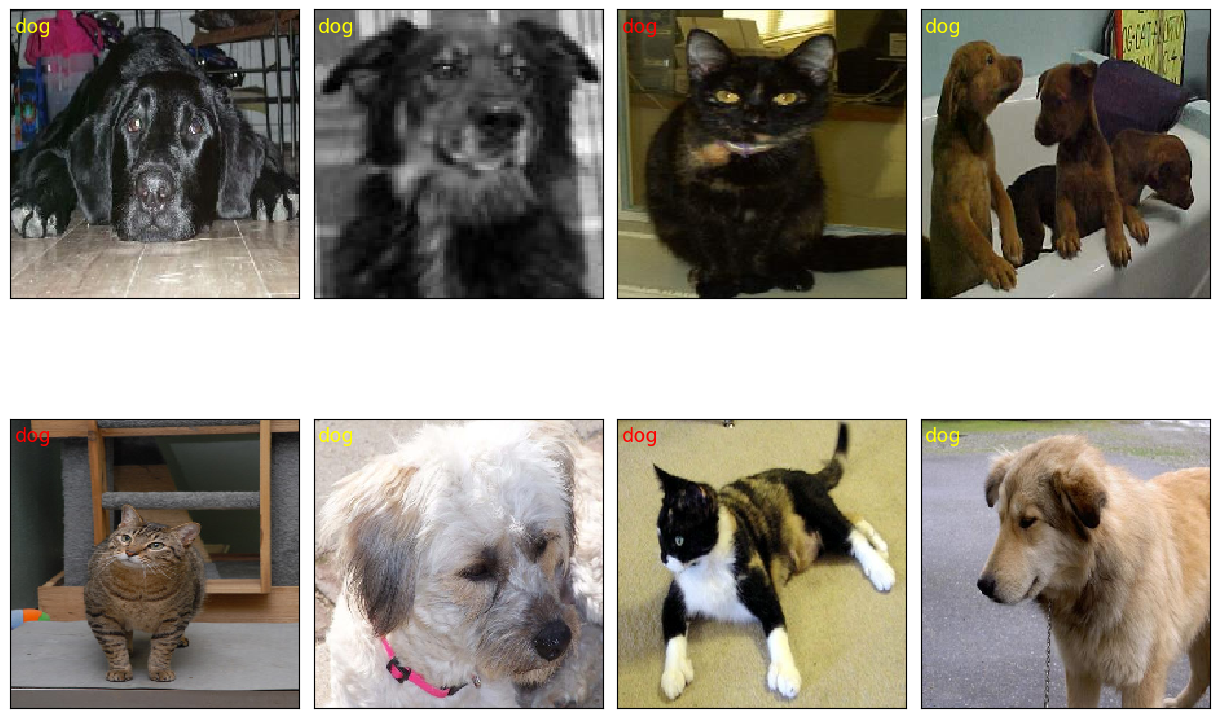

In [17]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2,4, i+1, xticks=[], yticks=[])
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    if pred_values[i] == np.argmax(label_batch[i]):
        ax.text(3,17,class_names[pred_values[i]], color='yellow', fontsize=14)
    else: 
        ax.text(3,17,class_names[pred_values[i]], color='red', fontsize=14)

============================================================================

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [4]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

In [5]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [6]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [7]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [8]:
from tensorflow.keras.models import load_model

In [9]:
Resnet152V2_model = load_model("./catanddog/Resnet152V2_catndog.keras")

2024-09-13 12:23:12.521449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 12:23:12.522656: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) Graphics)
2024-09-13 12:23:12.692210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:23:12.692383: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-09-13 12:23:12.692449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [10]:
Resnet152V2_pred =Resnet152V2_model.predict(valid_gen)
Resnet152V2_pred 

2024-09-13 12:23:29.734472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 21s 7s/step


2024-09-13 12:23:49.454165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:23:49.454288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6750 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-13 12:23:49.460618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 12:23:49.460777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6750 MB memory) -> physical PluggableDevice (device: 0, name: DM

array([[0.43348736, 0.57692885],
       [0.42864558, 0.586071  ],
       [0.4104202 , 0.5898413 ],
       [0.49780297, 0.5016785 ],
       [0.55144405, 0.44300294],
       [0.40527707, 0.5865385 ],
       [0.41116264, 0.593949  ],
       [0.5538893 , 0.44498914],
       [0.41871   , 0.58937365],
       [0.4140718 , 0.58642834],
       [0.5547886 , 0.446527  ],
       [0.55176914, 0.44334814],
       [0.4255072 , 0.5662678 ],
       [0.54571784, 0.43685678],
       [0.4271301 , 0.5895343 ],
       [0.39894658, 0.58002377],
       [0.43321168, 0.55844295],
       [0.4088827 , 0.6090725 ],
       [0.55282956, 0.4392337 ],
       [0.4009227 , 0.60371256],
       [0.553386  , 0.4445263 ],
       [0.4037899 , 0.5916911 ],
       [0.5527655 , 0.43931648],
       [0.4159866 , 0.6071099 ],
       [0.45071468, 0.54385126],
       [0.4416269 , 0.5761117 ],
       [0.4107559 , 0.60659474],
       [0.553684  , 0.44479388],
       [0.40212125, 0.6023166 ],
       [0.55825436, 0.45379317],
       [0.

In [11]:
class_names = ['cat','dog']
validation, label_batch =next(iter(valid_gen))
pred_values = np.argmax(Resnet152V2_pred, axis=1)



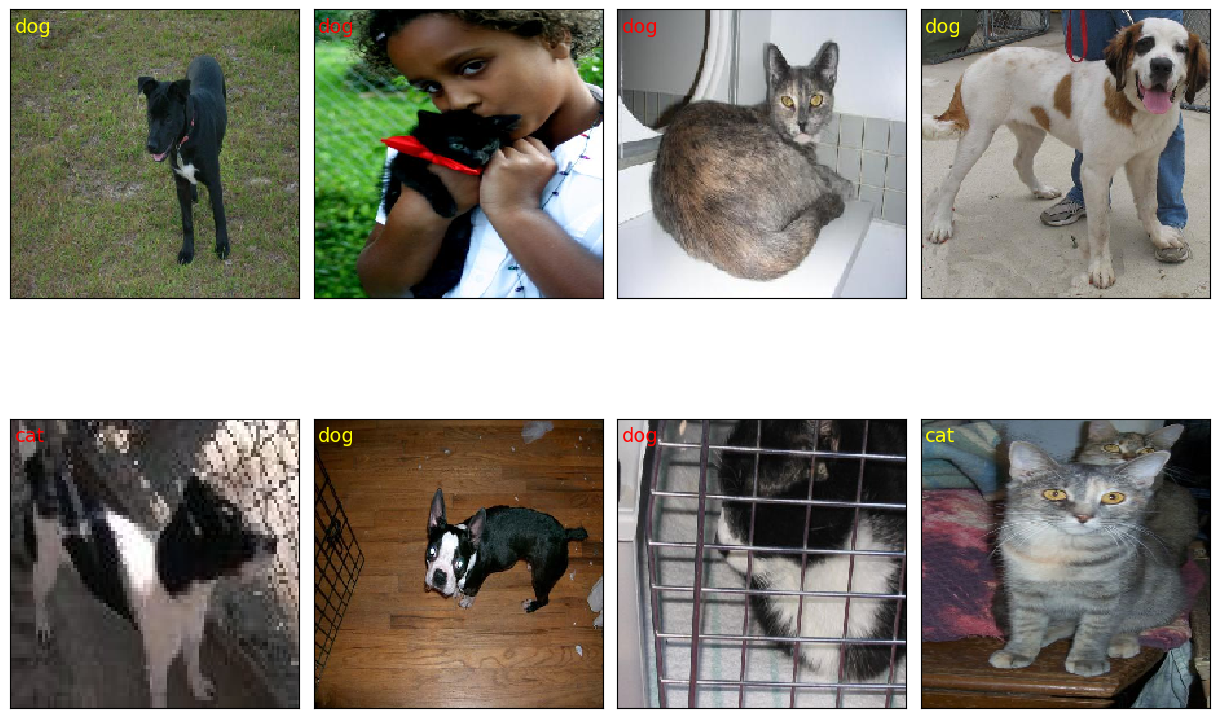

In [12]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2,4, i+1, xticks=[], yticks=[])
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    if pred_values[i] == np.argmax(label_batch[i]):
        ax.text(3,17,class_names[pred_values[i]], color='yellow', fontsize=14)
    else: 
        ax.text(3,17,class_names[pred_values[i]], color='red', fontsize=14)

# 텐서플로 허브에서 사전 훈련된 모델 받아서 개와 고양이 판별하기

In [13]:
# !pip install --upgrade tensorflow_hub

In [14]:
# import tensorflow_hub as hub

ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
model =Sequential()
model.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
                   input_shape=(224, 224, 3),
                   trainable=False))
model.add(Dense(2, activation ='softmax'))

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_hub_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [ ]:
history= model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

In [ ]:
ye_model = load_model("./model/Resnet152V2_tensor_hub_catndog_ye.keras", )